In [1]:
import cv2

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
def CannyEdge(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    cannyImage = cv2.Canny(blur, 60, 180)
    return cannyImage

In [5]:
def region_of_interest(image):
    height = image.shape[0]
    triangle = np.array([[(0, height),(600, 250),(1300, height),]], np.int32)
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, triangle, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [6]:
def getLines(image):
    lines = cv2.HoughLinesP(image, 0.3, np.pi/180, 100, np.array([]), minLineLength=100, maxLineGap=20)
    return lines

In [7]:
def displayLines(image, lines):
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4) #converting to 1d array
            cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return image

In [8]:
def getLineCoordinatesFromParameters(image, line_parameters):
    slope = line_parameters[0]
    intercept = line_parameters[1]
    y1 = image.shape[0]  # since line will always start from bottom of image
    y2 = int(y1 * (3.4 / 5))  # some random point at 3/5
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

In [9]:
def getSmoothLines(image, lines):
    left_fit = []  # will hold m,c parameters for left side lines
    right_fit = []  # will hold m,c parameters for right side lines

    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]

        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)

    # now we have got m,c parameters for left and right line, we need to know x1,y1 x2,y2 parameters
    left_line = getLineCoordinatesFromParameters(image, left_fit_average)
    right_line = getLineCoordinatesFromParameters(image, right_fit_average)
    return np.array([left_line, right_line])

In [10]:
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

# Main execution of the real time data

In [36]:
image = cv2.imread('road.jpg')
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


In [37]:
edged_image = CannyEdge(image)

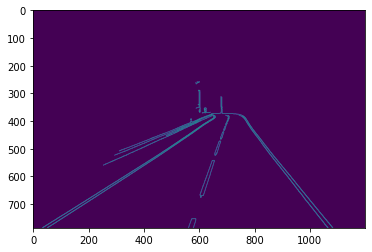

In [38]:
roi_image = region_of_interest(edged_image)
plt.imshow(roi_image)

In [39]:
lines = getLines(roi_image)

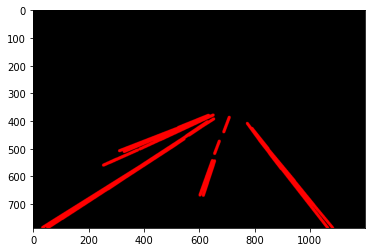

In [40]:
cropped_Image = region_of_interest(edged_image)
rho = 2
theta = np.pi/180
threshold = 100
lines = cv2.HoughLinesP(cropped_Image,rho, theta, threshold, np.array ([]), minLineLength=40, maxLineGap=5)
line_image = display_lines(image, lines)
plt.imshow(line_image)

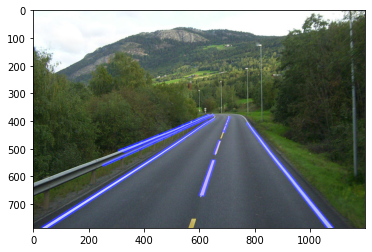

In [41]:
combo_image = cv2.addWeighted(image, 1, line_image, 1, 1)
combo_image = cv2.cvtColor(combo_image, cv2.COLOR_BGR2RGB) 
plt.imshow(combo_image)

In [47]:

cap = cv2.VideoCapture('night.mp4')
# cap = cv2.VideoCapture(0)
while(True):
    ret, frame = cap.read()
    image = frame

    edged_image = CannyEdge(image)
    roi_image = region_of_interest(edged_image)

    lines = getLines(roi_image)
    cropped_Image = region_of_interest(edged_image)
    
    rho = 2
    theta = np.pi/180
    threshold = 100
    lines = cv2.HoughLinesP(cropped_Image,rho, theta, threshold, np.array ([]), minLineLength=40, maxLineGap=5)
    line_image = display_lines(image, lines)
    
    combo_image = cv2.addWeighted(image, 1, line_image, 1, 1)
    cv2.imshow('Results',combo_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# 